In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/SNN_data

In [3]:
# Go to that directory where log files are saved 

In [ ]:
cd Column16_seq/

In [ ]:
!pwd

In [6]:
import os,re, pickle, random
import numpy as np
import pandas as pd
from itertools import chain
from bs4 import BeautifulSoup
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanAbsoluteError

import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, roc_curve, auc
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

In [7]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 54 kB/s 


In [8]:
from catboost import CatBoostRegressor

In [ ]:
def getInfo(file, ip_spks):

    """
    Args:
    file : Log files 
    ip_spks : Number of input neurons or pre-synaptic neurons

    return :
    df : Dataframe
    
    """

    with open(file) as f:
        soup = BeautifulSoup(f.read(), "html.parser")

    df = pd.DataFrame()

    # Making column names
    cols = ["Time(s)", "Column Number"]
    for i in range(ip_spks):
      cols.append("spk_ip_" + str(i))
      cols.append("#Spikes_" + str(i))
      cols.append("ISI_" + str(i))

    cols += ["#Spikes_out", "ISI_out"]

    time = [int(i.split(":")[1]) for i in re.findall(r"Time : \d+", soup.text)]

    df["Time(s)"] = time

    # Column number info
    col_num = [int(j.split(":")[1]) for j in re.findall("Column number: \d+",soup.text)]

    df["Column Number"] = col_num 

    # NeuronID info for each spike generating neuron
    n_id_info = re.findall("NeuronID: (.+)", soup.text)

    spikes_info = [list(map(int,re.findall(r'(\d+)', i))) for i in n_id_info]
    
    n_id_info_v1 = []

    for idx in range(0, len(spikes_info), ip_spks):
      
      var = list(chain.from_iterable((x[0],len(x)-1, x[1:]) for x in spikes_info[idx: idx + ip_spks]))
      
      n_id_info_v1.append(var)
  

    df[cols[2:-2]] = n_id_info_v1


    # Output column info
    out = re.findall("Output Neuron at column (.+)", soup.text)

    spikes_info_out = [list(map(int, re.findall(r'(\d+)', i))) for i in out]
    # print(spikes_info_out)
    out_info = []

    for i_out in spikes_info_out:
      out_info.append([len(i_out)-1, i_out[1:]])

    # Checking #instances
    assert len(out_info) == len(time) == len(col_num) == len(n_id_info_v1)
    
    df[cols[-2:]] = out_info


    return df

In [9]:
# To compute average ISI (Inter-spiking interval)
def getAvgIsi(x):

  if len(x) == 1:
    return x[0]%1000

  else:
    return sum([(x[i+1]%1000)- (x[i]%1000) for i in range(len(x)-1)])/(len(x)-1)

In [ ]:
# To make a directory to save all log files for each pre-synaptic neuron or input neuron
os.mkdir("files_16_raw")

In [ ]:
def SaveRawFile(dataframe, i, fol):
  """
  Args :
  dataframe: Dataframe
  i : Post-synaptic neuron ID
  fol : File name of post-synaptic neuron ID
  
  """

  columns = dataframe.columns
  f = pd.DataFrame()

  idx = 0
  for e in columns:
    
    if e.startswith("ISI_"):

      if e == "ISI_out":
          f[e] =  dataframe[e]
          f['Avg_ISI_out'] =  dataframe['ISI_out'].apply(lambda x: getAvgIsi(x))
        
      else:
        f[e] =  dataframe[e]
        f['Avg_ISI_'+str(idx)] =  dataframe['ISI_' + str(idx)].apply(lambda x: getAvgIsi(x))
        idx += 1

    else:
      f[e] = dataframe[e]

  f.to_excel("files_16_raw/" + fol + "/" + "Column" + str(i) + ".xlsx", index = False)
  

In [ ]:
fol_name = os.listdir("logs/")
assert len(fol_name) == 16
print(fol_name)

['Column_0', 'Column_2', 'Column_6', 'Column_9', 'Column_10', 'Column_14', 'Column_7', 'Column_12', 'Column_11', 'Column_1', 'Column_4', 'Column_8', 'Column_3', 'Column_5', 'Column_13', 'Column_15']


# Saving log files in the desirable and readable format

In [ ]:
for fol in fol_name:
  logs_list = [i for i in os.listdir("logs/"+ fol) if i.endswith(".txt")]

  os.mkdir("files_16_raw/"+ fol) 

  # Saving raw data in excel file
  for file_name in logs_list:
    print(f"Folder Name : {fol} | Column name : {file_name}.")
    col_num = int(file_name.split(".txt")[0][10:])
    df = getInfo("logs"+ '/' + fol + "/" + file_name, 16)
    SaveRawFile(df, col_num, fol)

In [ ]:
# Sort the name of file of post-synaptic neuron ID

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):

    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

In [ ]:
# To create a directory to save all features (Spike rate, Avg. ISI) and their ground truth (Observed ISI) 
os.mkdir("StackedFiles")

In [ ]:
"""
Extracting features (Spike rate, Avg. ISI) and their ground truth (Observed ISI) and then
apply breakout distribution and then data augmentation.

"""

def StackedFile(path, nG, fol):
    """
    Args:
    path : File name path for post-synaptic neuron ID
    nG : Number of post-synaptic neurons
    fol : post-synaptic neuron ID

    """
    files = [i for i in os.listdir(path) if i.endswith(".xlsx")]
    files.sort(key=natural_keys)  

    # print(files)

    increment = 0

    for i,f in enumerate(files):

        """
        Predicting only average ISI_out, not #Spikes_out
        """
        
        file = pd.read_excel(path + '/' + f)

        cols_drop = []

        for id in range(nG):
          cols_drop.append("spk_ip_" + str(id))
          cols_drop.append("ISI_" + str(id))

        cols_drop.append("ISI_out")

        file.drop(cols_drop, axis=1, inplace=True)

        file_v1 = file.reset_index(drop=True)


        X_train  = file_v1.drop(labels = ['Time(s)', 'Column Number', '#Spikes_out','Avg_ISI_out'], axis=1).values
        y_train =  file_v1['Avg_ISI_out'].values

        increment += 1
        X_train_v1 = np.concatenate([X_train[:, :increment*2], np.zeros((X_train.shape[0], X_train.shape[1] - (increment*2)))], axis =1)
        
        if i == 0:
          X_tr, y_tr =  X_train_v1, y_train
 
        else:
          X_tr1, y_tr1 =  X_train_v1, y_train

          X_tr = np.concatenate([X_tr, X_tr1])
          y_tr = np.concatenate([y_tr, y_tr1])

   
    with open("StackedFiles/X_train_stacked_" + fol + ".npy", 'wb') as f:
      np.save(f, X_tr)

    with open("StackedFiles/y_train_stacked_" + fol + ".npy", 'wb') as f:
      np.save(f, y_tr)


In [ ]:
# Saving the features and their ground truth for each column of crossbar array
for fol in fol_name:
  print("#" * 25 + " " + fol + " " + "#"*25)
  StackedFile(os.getcwd() + '/' + "files_16_raw/" + fol + "/", 16, fol)

In [10]:
def getBinary(y_true, y_pred, margin):
  
  """
  It will binarize the continuous values which are y_true and y_pred with
  the help of margin and threshold to plot ROC (Receiver operating characteristic).

  Args:
  y_true : Observed avg. ISI (continuous values)
  y_pred : Predicted avg. ISI (continuous values)
  margin : The margin is the obtained optimal MAE or a user can take loose margin as per his choice to incur more false alaram or false fault

  return:
  y_t : Binarized y_true
  y_p : Binarized y_pred

  The reason to opt for ROC curve because it offers an elegant way to
  plot true fault detection rate versus false fault detection rate.
 
  """

  thresh = pd.Series(y_true).median()   # We have taken median as a threshold because it is not impacted by the outliers
  y_t = []
  y_p = []

  for t,p in zip(y_true, y_pred):
    if np.abs(t - p) <= margin:
      if t> thresh:
        y_t.append(1)
        y_p.append(1)
      else:
        y_t.append(0)
        y_p.append(0)

    else:
      if (t > thresh) and (p > thresh):  # ex: t=60, p=80 but thresh = 55 --> t,p -> 1, therefore one of them has to be opposite to another because abs(t-p)>15.
        y_t.append(1)
        y_p.append(0)

      elif (t > thresh) and (p <= thresh):  # ex: t=60, p=40 but thresh = 55 --> t->1,  p-> 0, which satisfies the condition, one has to be opposite of another.
        y_t.append(1)
        y_p.append(0)

      elif (t <= thresh) and (p > thresh):  # ex: t=30, p=57 but thresh = 55 --> t->0,  p-> 1,
        y_t.append(0)
        y_p.append(1)

      elif (t <= thresh) and (p <= thresh): # ex: t=25, p=45 but thresh = 55 --> t->0, p-> 1, therefore one of them has to be opposite to another.
        y_t.append(0)
        y_p.append(1)
      

  y_t = np.array(y_t)
  y_p = np.array(y_p)

  return y_t, y_p

In [11]:
def plotROC(y_true, y_pred, reg, margin, color):

  """
  To plot ROC

  Args: 
  y_true : Observed avg. ISI
  y_pred : Predicted avg. ISI
  reg :  Regressor Name
  margin : The margin is the obtained optimal MAE or a user can take loose margin as per his choice to incur more false alaram or false fault
  color : Color

  return:
  y_t : Binarized y_true
  y_p : Binarized y_pred

  """

  y_t, y_p = getBinary(y_true, y_pred, margin)

  # print("y_true, y_pred")
  # print(y_true)
  # print(y_pred)
  
  fpr, tpr, _ = roc_curve(y_t, y_p )
  roc_auc = auc(fpr, tpr)

  print()
  print("False positive rate : ", fpr[1])
  print("True positive rate : ", tpr[1])
  print("ROC Area under curve : ", roc_auc)

  plt.figure(figsize = (6,6))
  lw = 2
  plt.plot(fpr, tpr, color= color, lw=lw, label=f"ROC curve (area = %0.2f) for {reg}." % roc_auc,linewidth=4)
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate", fontsize=15)
  plt.ylabel("True Positive Rate", fontsize=15)
  plt.title("Receiver operating characteristic example")
  plt.legend(loc="lower right")
  plt.show()

  return y_t, y_p

In [ ]:
# To create a directory for saving scaler and model for each column
os.mkdir('Scaler')
os.mkdir('Models')

In [12]:
def DeepNN(type, ip_shape = None):

  """
  Args:
  type : ANN or CNN

  return:
  ANN or CNN model

  """

  
  hidden_units = 256
  n_filters = 16
  learning_rate = 0.001 # 0.001

  # Initialize the weights with He normalization
  he_init = tf.keras.initializers.HeNormal()

  if type == "CNN":

    model = Sequential([
        Conv2D(filters= n_filters, kernel_size=(3, 3), kernel_initializer=he_init, activation='relu', input_shape=ip_shape),BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(filters= n_filters, kernel_size=(1, 1), kernel_initializer=he_init, activation= 'relu'),BatchNormalization(),
        MaxPooling2D((1, 1)),
        Flatten(),
        Dense(hidden_units, kernel_initializer=he_init, activation='relu'),
        Dropout(0.3),
        Dense(1, kernel_initializer=he_init, activation='linear')
        ])
    
    # Loss function
    msle =  MeanSquaredError() 
    model.compile(loss=msle, optimizer=Adam(learning_rate=learning_rate), metrics=[MeanAbsoluteError()])

    return model


  elif type == "ANN":
    model = Sequential([
      Dense(hidden_units, kernel_initializer=he_init, activation='relu'),
      Dropout(0.2),
      Dense(hidden_units, kernel_initializer=he_init, activation='relu'),
      Dropout(0.4),
      Dense(1, kernel_initializer=he_init, activation='linear')])
    
    # Loss function
    msle =  MeanSquaredError() 
    model.compile(loss=msle, optimizer=Adam(learning_rate=learning_rate), metrics=[MeanAbsoluteError()])

    return model



In [ ]:
"""
To test which model is performing the best and then in the below cell. We will train that model for
all columns of 16 by 16 crossbar array.
"""

def test(id, ip_shape, scaling_mode):
    """
    Args:
    id : Synaptic neuron id or column id
    scaling_mode : Type of scaling technique
    ip_shape : Dimension of an example (Mainly for CNN)

    """

    row, col, chn = ip_shape
    print("#"*25 + " " + "Column" + str(id) +" " + "#"*25)
    with open("StackedFiles/X_train_stacked_Column_" + str(id) + ".npy", 'rb') as f:
      X = np.load(f)

    with open("StackedFiles/y_train_stacked_Column_" + str(id) + ".npy", 'rb') as f:
      y = np.load(f)

    print()

    # Splitting the dataset into training, validation, and test set in (4:0.5:0.5) ratio
    X_train, X_val, y_train, y_val = train_test_split(X, y/10, test_size=0.20, random_state=42)   
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=42)

    print("X_train : ", X_train.shape)
    print("y_train : ", y_train.shape)
    print("X_val : ", X_val.shape)
    print("y_val : ", y_val.shape)
    print("X_test : ", X_test.shape)
    print("y_test : ", y_test.shape)
    print()


    # Standard Scaling
    if scaling_mode == 'std':
      print("Standard Scaling",'\n')
      scaler = StandardScaler()
      x_train_scaled = scaler.fit_transform(X_train)
      x_test_scaled = scaler.transform(X_test)
      x_val_scaled = scaler.transform(X_val)
      

    # Min-max Scaling
    elif scaling_mode == "minmax":
      print("Minmax Scaling \n")
      scaler = MinMaxScaler()
      x_train_scaled = scaler.fit_transform(X_train)
      x_test_scaled = scaler.transform(X_test)
      x_val_scaled = scaler.transform(X_val)


    # Training model
    model_name = ["LinearRegression", "GradientBoostingRegressor", "RandomForestRegressor", "AdaBoostRegressor", "XGBRegressor", 
                  "LGBMRegressor", "CatBoostRegressor", "ANN", "CNN"] # , "SVR"

    reg1 = LinearRegression()
    reg2 = GradientBoostingRegressor(learning_rate=0.15, n_estimators=200, min_samples_leaf=1, max_depth=3, random_state=0)
    reg3 = RandomForestRegressor(n_estimators=300, criterion='squared_error', max_depth=7, random_state=0)
    reg4 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7, random_state=42), n_estimators=100, learning_rate=0.01, loss='square')
    reg5 = XGBRegressor(n_estimators = 200, max_depth = 5, learning_rate=0.03, booster = 'gbtree', tree_method = 'auto',random_state=42)
    reg6 = LGBMRegressor(n_estimators = 200, boosting_type = 'dart',max_depth = 5, num_leaves = 25, learning_rate=0.25, random_state =42)
    reg7 = CatBoostRegressor(learning_rate = 0.05, depth = 8,boosting_type = 'Ordered',loss_function = "RMSE",verbose = False)
    #reg8 = SVR(kernel ='linear')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose=1, patience=5, mode= 'min')
    ann = DeepNN('ANN')
    cnn = DeepNN('CNN', (row, col, chn))

    # Mean absoluter error for each regressor model for training, validation, and test set
    MAEs = []
    
    for ix,reg in enumerate([reg1, reg2, reg3, reg4, reg5, reg6, reg7, ann, cnn]): # reg8

      if len(model_name) -1 == ix:
        padding_tr = np.zeros((x_train_scaled.shape[0], 2))
        padding_val = np.zeros((x_val_scaled.shape[0], 2))
        padding_te = np.zeros((x_test_scaled.shape[0], 2))
        x_tr = np.concatenate([padding_tr, x_train_scaled, padding_tr], axis=1).reshape((x_train_scaled.shape[0],row, col, chn))
        x_val = np.concatenate([padding_val, x_val_scaled, padding_val], axis=1).reshape((x_val_scaled.shape[0],row, col, chn))
        x_te = np.concatenate([padding_te, x_test_scaled, padding_te], axis=1).reshape((x_test_scaled.shape[0],row, col, chn))
        reg.fit(x_tr, y_train, epochs=151, batch_size=128, callbacks=[early_stopping], 
                                                    validation_data=(x_val, y_val), verbose=0)
      elif len(model_name)-2 == ix:
        reg.fit(x_train_scaled, y_train, epochs=151, batch_size=128, callbacks=[early_stopping], validation_data=(x_val_scaled, y_val), verbose=0)

      else:
        reg.fit(x_train_scaled, y_train)

      if len(model_name) -1 == ix:
        tr_mae = np.round(mean_absolute_error(y_train, reg.predict(x_tr)), 5)
        val_mae = np.round(mean_absolute_error(y_val, reg.predict(x_val)), 5)
        test_mae = np.round(mean_absolute_error(y_test, reg.predict(x_te)), 5)

      else:
        tr_mae = np.round(mean_absolute_error(y_train, reg.predict(x_train_scaled)), 5)
        val_mae = np.round(mean_absolute_error(y_val, reg.predict(x_val_scaled)), 5)
        test_mae = np.round(mean_absolute_error(y_test, reg.predict(x_test_scaled)), 5)

      reg_name = model_name[ix]

      print(f"MAE of {reg_name} on training set is {tr_mae}.")
      print(f"MAE of {reg_name} on validation set is {val_mae}.")
      print(f"MAE of {reg_name} on test set is {test_mae}.")
      print()
      print("*"*71)
      print()

      MAEs.append(reg_name + " : | Training MAE : " + str(tr_mae) + " | Validation MAE : " + str(val_mae) + " | Test MAE : " + str(test_mae))

    print("Results :\n")
    for result in MAEs:
      print(result)

In [ ]:
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Test run for Column_id : 0 to check which model is performing better
test(0, ip_shape = (6,6,1), scaling_mode= "minmax")

######################### Column0 #########################

X_train :  (64012, 32)
y_train :  (64012,)
X_val :  (8002, 32)
y_val :  (8002,)
X_test :  (8002, 32)
y_test :  (8002,)

Minmax Scaling 

MAE of LinearRegression on training set is 4.4653.
MAE of LinearRegression on validation set is 4.30569.
MAE of LinearRegression on test set is 4.4753.

***********************************************************************

MAE of GradientBoostingRegressor on training set is 3.47238.
MAE of GradientBoostingRegressor on validation set is 3.4473.
MAE of GradientBoostingRegressor on test set is 3.5823.

***********************************************************************

MAE of RandomForestRegressor on training set is 3.51627.
MAE of RandomForestRegressor on validation set is 3.50781.
MAE of RandomForestRegressor on test set is 3.62861.

***********************************************************************

MAE of AdaBoostRegressor on training set is 3.7016.
MAE of AdaBoostRegressor on 

In [ ]:
def training(nG, ip_shape, scaling_mode):

  """
  Args:
  nG : NUmber of post-synaptic neurons
  scaling_mode : Type of scaling technique
  ip_shape : Dimension of an example (Mainly for CNN)

  return :
  MAE of each model that is trained for each post-synaptic neuron column

  """

  MAEs = [[], [], [], [], []]
  row, col, chn = ip_shape

  for id in range(nG):

    print("#"*25 + " " + "Column" + str(id) +" " + "#"*25)
    with open("StackedFiles/X_train_stacked_Column_" + str(id) + ".npy", 'rb') as f:
      X = np.load(f)

    with open("StackedFiles/y_train_stacked_Column_" + str(id) + ".npy", 'rb') as f:
      y = np.load(f)

    print()

    # Splitting the dataset into training, validation, and test set in (4:0.5:0.5) ratio
    X_train, X_val, y_train, y_val = train_test_split(X, y/10, test_size=0.20, random_state=42)   # y = y/10 (To convert into decisecond window for better fit)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=42)

    print("X_train : ", X_train.shape)
    print("y_train : ", y_train.shape)
    print("X_val : ", X_val.shape)
    print("y_val : ", y_val.shape)
    print("X_test : ", X_test.shape)
    print("y_test : ", y_test.shape)
    print()


    # Standard Scaling
    if scaling_mode == 'std':
      print("Standard Scaling",'\n')
      scaler = StandardScaler()
      x_train_scaled = scaler.fit_transform(X_train)
      x_test_scaled = scaler.transform(X_test)
      x_val_scaled = scaler.transform(X_val)

      # Saving scaler for each column
      with open(os.getcwd() + "/Scaler/" + "std_Column_" + str(id) + ".pkl" , 'wb') as file:  
        pickle.dump(scaler, file)
      

    # Min-max Scaling
    elif scaling_mode == "minmax":
      print("Minmax Scaling \n")
      scaler = MinMaxScaler()
      x_train_scaled = scaler.fit_transform(X_train)
      x_test_scaled = scaler.transform(X_test)
      x_val_scaled = scaler.transform(X_val)

      # Saving scaler for each column
      with open(os.getcwd() + "/Scaler/" + "minmax_Column_" + str(id) + ".pkl" , 'wb') as file:  
        pickle.dump(scaler, file)


    # Training model
    model_name = ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor", "ANN", "CNN"]

    reg1 = XGBRegressor(n_estimators = 200, max_depth = 5, learning_rate=0.03, booster = 'gbtree', tree_method = 'auto',random_state=42)
    reg2 = LGBMRegressor(n_estimators = 200, boosting_type = 'dart',max_depth = 5, num_leaves = 25, learning_rate=0.25, random_state =42)
    reg3 = CatBoostRegressor(learning_rate = 0.05, depth = 8,boosting_type = 'Ordered',loss_function = "RMSE",verbose = False)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose=1, patience=5, mode= 'min')
    ann = DeepNN('ANN')
    cnn = DeepNN('CNN', (row, col, chn))


    for ix,reg in enumerate([reg1, reg2, reg3, ann, cnn]): 

      if len(model_name) -1 == ix:
        padding_tr = np.zeros((x_train_scaled.shape[0], 2))
        padding_val = np.zeros((x_val_scaled.shape[0], 2))
        padding_te = np.zeros((x_test_scaled.shape[0], 2))
        x_tr = np.concatenate([padding_tr, x_train_scaled, padding_tr], axis=1).reshape((x_train_scaled.shape[0],row, col, chn))
        x_val = np.concatenate([padding_val, x_val_scaled, padding_val], axis=1).reshape((x_val_scaled.shape[0],row, col, chn))
        x_te = np.concatenate([padding_te, x_test_scaled, padding_te], axis=1).reshape((x_test_scaled.shape[0],row, col, chn))
        reg.fit(x_tr, y_train, epochs=151, batch_size=128, callbacks=[early_stopping], validation_data=(x_val, y_val), verbose=0)
        
      elif len(model_name)-2 == ix:
        reg.fit(x_train_scaled, y_train, epochs=151, batch_size=128, callbacks=[early_stopping], validation_data=(x_val_scaled, y_val), verbose=0)

      else:
        reg.fit(x_train_scaled, y_train)

      if len(model_name) -1 == ix:
        tr_mae = np.round(mean_absolute_error(y_train, reg.predict(x_tr)), 5)
        val_mae = np.round(mean_absolute_error(y_val, reg.predict(x_val)), 5)
        test_mae = np.round(mean_absolute_error(y_test, reg.predict(x_te)), 5)

      else:
        tr_mae = np.round(mean_absolute_error(y_train, reg.predict(x_train_scaled)), 5)
        val_mae = np.round(mean_absolute_error(y_val, reg.predict(x_val_scaled)), 5)
        test_mae = np.round(mean_absolute_error(y_test, reg.predict(x_test_scaled)), 5)

      reg_name = model_name[ix]

      print(f"MAE of {reg_name} on training set is {tr_mae}.")
      print(f"MAE of {reg_name} on validation set is {val_mae}.")
      print(f"MAE of {reg_name} on test set is {test_mae}.")
      print()
      print("*"*71)
      print()

      if reg_name == "XGBRegressor":
        MAEs[0].append((tr_mae, val_mae, test_mae))

      elif reg_name == "LGBMRegressor":
        MAEs[1].append((tr_mae, val_mae, test_mae))

      elif reg_name == "CatBoostRegressor":
        MAEs[2].append((tr_mae, val_mae, test_mae))

      elif reg_name == "ANN":
        MAEs[3].append((tr_mae, val_mae, test_mae))

      elif reg_name == "CNN":
        MAEs[4].append((tr_mae, val_mae, test_mae))


      if reg_name in ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor"]:
        # Saving regressor model for each column
        with open(os.getcwd() + "/Models/" + reg_name + "_column_" + str(id) + ".pkl" , 'wb') as file:  
          pickle.dump(reg, file)

      else:
        reg.save(os.getcwd() + "/Models/" + reg_name + "_column_" + str(id) +".h5")

  print()
  print("Results :\n")
  for ix1,result in enumerate(MAEs):
    print("*"*25 + " " + model_name[ix1] + " " + "*"*25)
    for col_res in result:
      tr_mae, val_mae, test_mae = col_res
      print(model_name[ix1] + " : | Training MAE : " + str(tr_mae) + " | Validation MAE : " + str(val_mae) + " | Test MAE : " + str(test_mae))

    print()
    print()

    
  return MAEs
    

In [ ]:
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

MAEs = training(nG = 16, ip_shape = (6,6,1), scaling_mode = "minmax")

######################### Column0 #########################

X_train :  (64012, 32)
y_train :  (64012,)
X_val :  (8002, 32)
y_val :  (8002,)
X_test :  (8002, 32)
y_test :  (8002,)

Minmax Scaling 

[10:01:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of XGBRegressor on training set is 3.40087.
MAE of XGBRegressor on validation set is 3.40202.
MAE of XGBRegressor on test set is 3.51631.

***********************************************************************

MAE of LGBMRegressor on training set is 3.32698.
MAE of LGBMRegressor on validation set is 3.3366.
MAE of LGBMRegressor on test set is 3.47014.

***********************************************************************

MAE of CatBoostRegressor on training set is 3.37796.
MAE of CatBoostRegressor on validation set is 3.37318.
MAE of CatBoostRegressor on test set is 3.47383.

***********************************************************************

Epoch 11: 

In [ ]:
# Saving MAEs to numpy array
with open('MAEs.npy', 'wb') as f:
    np.save(f, np.array(MAEs))

In [ ]:
# Loading MAEs to numpy array
with open('MAEs.npy', 'rb') as f:
    MAEs = np.load(f)

In [ ]:
MAEs.shape

(5, 16, 3)

In [ ]:
def getMu_Std(maes):
  """
  Args:
  maes :  Mean absolute error for all columns for each model

  return :
  mu, std : Mean and Standard deviation of performance of each model

  """

  # Fetching MAE of test set across each column for each model
  mae_te = [[j[-1] for j in i] for i in maes]

  # Mean of MAE of test set
  mu = np.mean(mae_te, axis=1)

  # Standard deviation of MAE of test set
  std = np.sqrt(np.var(mae_te, axis=1))

  return mu, std

In [ ]:
mu, std = getMu_Std(MAEs)

In [ ]:
# ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor", "ANN", "CNN"]
mu

array([3.45714188, 3.40942875, 3.42635437, 3.48197563, 3.54903375])

In [ ]:
# ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor", "ANN", "CNN"]
std

array([0.08585044, 0.09019829, 0.0852567 , 0.12188707, 0.13194104])

In [13]:
def getPrediction(id, model_name, scaling_mode, ip_shape):
  
    """
    Args:
    id : Synaptic neuron id or column id
    model_name : Name of the regressor model
    scaling_mode : Type of scaling technique
    ip_shape : Dimension of an example (Mainly for CNN)

    return:
    pred : Prediction
    y_test : Ground truth of test set

    """

    row, col, chn = ip_shape
    print("#"*25 + " " + "Column" + str(id) +" " + "#"*25)

    with open("StackedFiles/X_train_stacked_Column_" + str(id) + ".npy", 'rb') as f:
      X = np.load(f)

    with open("StackedFiles/y_train_stacked_Column_" + str(id) + ".npy", 'rb') as f:
      y = np.load(f)

    print()

    # Splitting the dataset into training, validation, and test set in (4:0.5:0.5) ratio
    X_train, X_val, y_train, y_val = train_test_split(X, y/10, test_size=0.20, random_state=42)  
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=42)

    print("X_test : ", X_test.shape)
    print("y_test : ", y_test.shape)
    print()


    # Standard Scaling
    if scaling_mode == 'std':
      print("Using Standard Scaling",'\n')

      # Loading the scaler for each column
      with open(os.getcwd() + "/Scaler/" + "std_Column_" + str(id) + ".pkl", 'rb') as file:  
          scaler = pickle.load(file)
    
      X_test = scaler.transform(X_test)
      

    # Min-max Scaling
    elif scaling_mode == "minmax":
      print("Using Minmax Scaling \n")

      # Loading the scaler for each column
      with open(os.getcwd() + "/Scaler/" + "minmax_Column_" + str(id) + ".pkl", 'rb') as file:  
          scaler = pickle.load(file)

      X_test = scaler.transform(X_test)
      

    if model_name in ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor"]:
      # Loading the regressor model for each column
      with open(os.getcwd() + "/Models/" + model_name + "_column_" + str(id) + ".pkl", 'rb') as file:  
        regressor = pickle.load(file)
        pred = regressor.predict(X_test)

    else:
      regressor = tf.keras.models.load_model(os.getcwd() +  "/Models/" + model_name + "_column_" + str(id) +".h5", compile=False)

      if model_name == "CNN":
        padding_te = np.zeros((X_test.shape[0], 2))
        X_test = np.concatenate([padding_te, X_test, padding_te], axis=1).reshape((X_test.shape[0],row, col, chn))
        pred = regressor.predict(X_test)
      else:
        pred = regressor.predict(X_test)
  
    return pred, y_test, X_test, regressor

######################### Column0 #########################

X_test :  (8002, 32)
y_test :  (8002,)

Using Minmax Scaling 


False positive rate :  0.07442557442557443
True positive rate :  0.7178589294647324
ROC Area under curve :  0.821716677519579


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


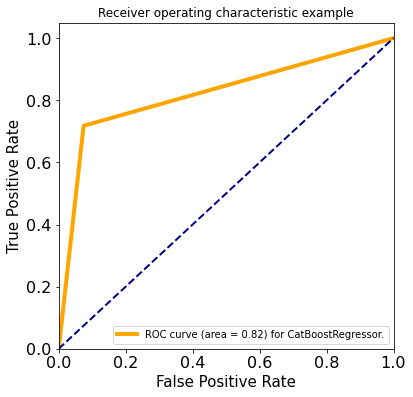

In [14]:
models_name = ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor", "ANN", "CNN"]
margin = 3
reg_name = models_name[2]

# For column id 0 for CatBoostRegressor with Minmax scaling
y_pred, y_test, X_test_reg, regressor_catboost = getPrediction(id= 0 , model_name = reg_name, scaling_mode = "minmax", ip_shape=(6,6,1))
y_t, y_p = plotROC(y_test, y_pred, reg_name, margin, 'orange') # "lightgreen", 'deeppink'

######################### Column0 #########################

X_test :  (8002, 32)
y_test :  (8002,)

Using Minmax Scaling 


False positive rate :  0.07092907092907093
True positive rate :  0.7853926963481741
ROC Area under curve :  0.8572318127095515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


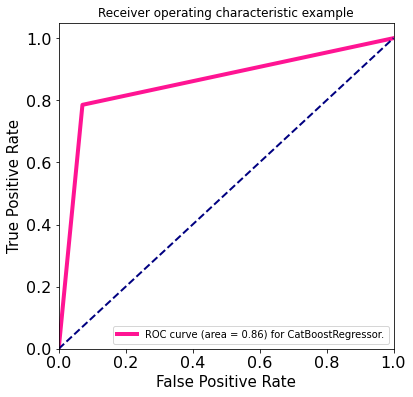

In [15]:
models_name = ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor", "ANN", "CNN"]
margin = 5
reg_name = models_name[2]

# For column id 0 for CatBoostRegressor with Minmax scaling
y_pred, y_test,_,_ = getPrediction(id= 0 , model_name = reg_name, scaling_mode = "minmax", ip_shape=(6,6,1))
y_t, y_p = plotROC(y_test, y_pred, reg_name, margin, 'deeppink') # "lightgreen", 'deeppink'

######################### Column0 #########################

X_test :  (8002, 32)
y_test :  (8002,)

Using Minmax Scaling 


False positive rate :  0.07317682317682318
True positive rate :  0.7341170585292647
ROC Area under curve :  0.8304701176762207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


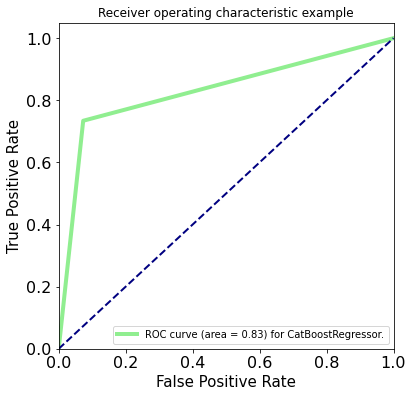

In [16]:
models_name = ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor", "ANN", "CNN"]
margin = 3.4
reg_name = models_name[2]

# For column id 0 for CatBoostRegressor with Minmax scaling
y_pred, y_test,_,_ = getPrediction(id= 0 , model_name = reg_name, scaling_mode = "minmax", ip_shape=(6,6,1))
y_t, y_p = plotROC(y_test, y_pred, reg_name, margin, "lightgreen") # "lightgreen", 'deeppink'

# Prediction versus ground truth

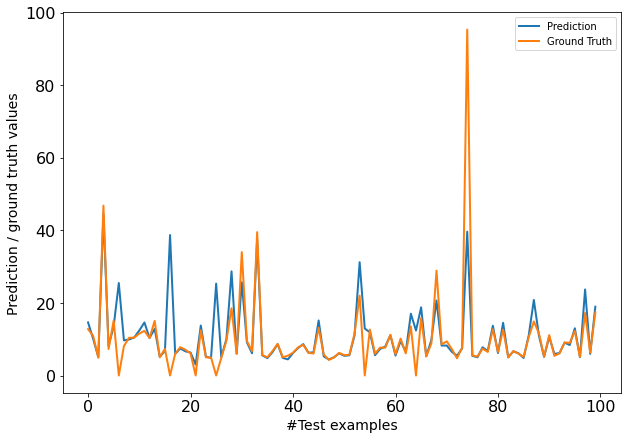

In [17]:
# Prediction versus ground truth

plt.figure(figsize = (10,7))
plt.plot(y_pred[:100],linewidth=2, )
plt.plot(y_test[:100],linewidth=2, )
plt.ylabel("Prediction / ground truth values", fontsize=14)
plt.xlabel("#Test examples", fontsize=14)
plt.legend(['Prediction','Ground Truth' ])

# Detecting missing and spurious spikes

In [10]:
def getOutput_spikes_with_some_missing(output_spikes, seed_num, percent_num):

  """
  Args:
  output_spikes : Output spikes for an example
  seed_num :  Seed number
  percent_num : Number of spikes to be removed  based on percentage

  return:
  Output spikes with aribitarily removing some spikes based on given percentage

  """
  output_spikes = np.array(output_spikes)
  np.random.seed(seed_num)
  idx = np.random.permutation(len(output_spikes))
  choose_idx = np.sort(idx[:-percent_num])
  out_spikes = output_spikes[choose_idx]

  return getAvgIsi(out_spikes)

In [11]:
def getOutput_spikes_with_some_Spurious_spikes(output_spikes, seed_num, percent_num):

  """
  Args:
  output_spikes : Output spikes for an example
  seed_num :  Seed number
  percent_num : Number of spikes to be introduced as spurious ones based on percentage

  return:
  Output spikes with an introduction of aribitarily spurious spikes based on given percentage

  """

  output_spikes = np.array(output_spikes)
  idx = np.random.randint(1, len(output_spikes), percent_num )

  for choose_idx in idx:

      while True:

        spike_t_minus_1 = output_spikes[choose_idx-1]
        spike_t = output_spikes[choose_idx]
        difference = spike_t - spike_t_minus_1

        if difference//2 > 8:
          output_spikes =  np.insert(output_spikes, choose_idx, output_spikes[choose_idx-1] + difference//2)
          break
        
        elif difference//2 > 6:
          output_spikes =  np.insert(output_spikes, choose_idx, output_spikes[choose_idx-1] + difference//2)
          break

        elif difference//2 > 4:
          output_spikes =  np.insert(output_spikes, choose_idx, output_spikes[choose_idx-1] + difference//2)
          break

        elif difference//2 > 2:
          output_spikes =  np.insert(output_spikes, choose_idx, output_spikes[choose_idx-1] + difference//2)
          break

        elif difference//2 > 1:
          output_spikes =  np.insert(output_spikes, choose_idx, output_spikes[choose_idx-1] + difference//2)
          break

        else:
          while True:
            choose_idx = np.random.randint(1, len(output_spikes))
            if choose_idx not in idx:
              break
        
  return getAvgIsi(output_spikes)

In [12]:
def getData(id, mode, percent = None):
  
    """
    Args:
    id : Synaptic neuron id or column id
    mode : Unseen nominal test samples or missing
    percent : Only for missing mode (either 15% or 20% or 25%)

    return:
    X,y 

    """

    with open("StackedFiles_nominal/X_unseen_stacked_Column_" + str(id) + ".npy", 'rb') as f:
        X = np.load(f)

    with open("StackedFiles_nominal/y_unseen_stacked_Column_" + str(id) + ".npy", 'rb') as f:
        y = np.load(f, allow_pickle=True)


    if mode == "missing":

      if percent == 15:
        y = np.array([getOutput_spikes_with_some_missing(eval(i), 44, percent_num= int(np.ceil(len(eval(i))* (5/100)))*3 ) for i in y])

      elif percent == 20:
        y = np.array([getOutput_spikes_with_some_missing(eval(i), 45, percent_num= int(np.ceil(len(eval(i))* (5/100)))*4 ) for i in y])

      elif percent == 25:
        y = np.array([getOutput_spikes_with_some_missing(eval(i), 45, percent_num= int(np.ceil(len(eval(i))* (5/100)))*5 ) for i in y])


    elif mode == "spurious":

      if percent == 15:
        y = np.array([getOutput_spikes_with_some_Spurious_spikes(eval(i), 42, percent_num= int(np.ceil(len(eval(i))* (5/100)))*3 ) for i in y])

      elif percent == 20:
        y = np.array([getOutput_spikes_with_some_Spurious_spikes(eval(i), 42, percent_num= int(np.ceil(len(eval(i))* (5/100)))*4 ) for i in y])

      elif percent == 25:
        y = np.array([getOutput_spikes_with_some_Spurious_spikes(eval(i), 42, percent_num= int(np.ceil(len(eval(i))* (5/100)))*5 ) for i in y])

    else:
      y = np.array([getAvgIsi(eval(i)) for i in y])

    # print("getData:",y)
    return X, y  

    

In [13]:
def getResult(id, scaling_mode, X, model_name, ip_shape = None):

    row, col, chn = ip_shape

    # Standard Scaling
    if scaling_mode == 'std':
      print("Using Standard Scaling",'\n')

      # Loading the scaler for each column
      with open(os.getcwd() + "/Scaler/" + "std_Column_" + str(id) + ".pkl", 'rb') as file:  
          scaler = pickle.load(file)
    
      X_test_scaled = scaler.transform(X)
      

    # Min-max Scaling
    elif scaling_mode == "minmax":

      # Loading the scaler for each column
      with open(os.getcwd() + "/Scaler/" + "minmax_Column_" + str(id) + ".pkl", 'rb') as file:  
          scaler = pickle.load(file)

      X_test_scaled = scaler.transform(X)

    
 
    if model_name in ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor"]:
      # Loading the regressor model for a column
      with open(os.getcwd() + "/Models/" + model_name + "_column_" + str(id) + ".pkl", 'rb') as file:  
        regressor = pickle.load(file)
        pred = regressor.predict(X_test_scaled)

    else:
      regressor = tf.keras.models.load_model(os.getcwd() +  "/Models/" + model_name + "_column_" + str(id) +".h5", compile=False)

      if model_name == "CNN":
        padding_te = np.zeros((X_test_scaled.shape[0], 2))
        X_test_scaled = np.concatenate([padding_te, X_test_scaled, padding_te], axis=1).reshape((X_test_scaled.shape[0],row, col, chn))
        pred = regressor.predict(X_test_scaled)
      else:
        pred = regressor.predict(X_test_scaled)

    return pred


In [14]:
model_name = "CatBoostRegressor"
ip_shape = (6,6,1)
scaling_mode = "minmax"
optimal_mae = 3.42635437 

In [15]:
def getSpuriousSpikesResults(nG, model_name, scaling_mode, ip_shape):

  y_nominal = []
  pred = []
  y_spurious_15 = []  
  y_spurious_20 = []  
  y_spurious_25 = []  

  # Nominal and spurious case

  for id in range(nG):

      X, y = getData(id =id, mode = "Nominal", percent = None)
      _, y_spur_15 = getData(id =id, mode = "spurious", percent = 15)
      _, y_spur_20 = getData(id =id, mode = "spurious", percent = 20)
      _, y_spur_25 = getData(id =id, mode = "spurious", percent = 25)
      pred_nom = getResult(id, scaling_mode, X, model_name, ip_shape)
      pred.append(pred_nom)
      y_nominal.append(y/10)
      y_spurious_15.append(y_spur_15/10)
      y_spurious_20.append(y_spur_20/10)
      y_spurious_25.append(y_spur_25/10)
        
  if model_name in ["ANN", "CNN"]:
    y_nominal = np.hstack([yn.flatten() for yn in y_nominal])
    pred = np.hstack([p.flatten() for p in pred])
    y_spurious_15 = np.hstack([ys.flatten() for ys in y_spurious_15])
    y_spurious_20 = np.hstack([ys.flatten() for ys in y_spurious_20])
    y_spurious_25 = np.hstack([ys.flatten() for ys in y_spurious_25])

  else:
    y_nominal = np.hstack(y_nominal)
    pred = np.hstack(pred)
    y_spurious_15 = np.hstack(y_spurious_15)
    y_spurious_20 = np.hstack(y_spurious_20)
    y_spurious_25 = np.hstack(y_spurious_25)


  return y_nominal, pred, y_spurious_15, y_spurious_20, y_spurious_25


In [16]:
# CatBoost
y_nominal, pred, y_spurious_15, y_spurious_20, y_spurious_25=getSpuriousSpikesResults(16, model_name=model_name, scaling_mode=scaling_mode, ip_shape= ip_shape)

In [17]:
# Mapping only 37.65% crosspoints of (16 by 16) crossbar array for unseen logs that are mentioned in the .cpp file

# 15% Spurious spikes
detected_spur_15 =  (np.abs(pred - y_spurious_15) > optimal_mae).sum()
print(detected_spur_15/len(pred))

0.2426470588235294


In [18]:
# 20% Spurious spikes
detected_spur_20 =  (np.abs(pred - y_spurious_20) > optimal_mae).sum()
print(detected_spur_20/len(pred))

0.5


In [19]:
# 25% Spurious spikes
detected_spur_25 =  (np.abs(pred - y_spurious_25) > optimal_mae).sum()
print(detected_spur_25/len(pred))

0.7426470588235294


In [20]:
def getPred_missing(nG, percent_num, modelName):

  y_miss = []
  pred_miss = []

  # For missing spikes

  for id in range(nG):

      X, y = getData(id =id, mode = "missing", percent = percent_num)
      pred_miss.append(getResult(id, scaling_mode, X, modelName, ip_shape))
      
      y_miss.append(y/10)
        
  y_miss = np.hstack(y_miss)

  if modelName in ["ANN", "CNN"]:
    pred_miss = np.hstack([p.flatten() for p in pred_miss])
  else:
    pred_miss = np.hstack(pred_miss)
  
  return y_miss, pred_miss

In [21]:
# For 15% missing spikes
y_miss_15, pred_miss_15 = getPred_missing(nG = 16, percent_num = 15, modelName = model_name)
detected_missed_15 =  (np.abs(y_miss_15 - pred_miss_15) > optimal_mae).sum()
print(detected_missed_15/len(y_miss_15))

0.7941176470588235


In [22]:
# For 20% missing spikes
y_miss_20, pred_miss_20 = getPred_missing(nG = 16, percent_num = 20, modelName = model_name)
detected_missed_20 =  (np.abs(y_miss_20 - pred_miss_20) > optimal_mae).sum()
print(detected_missed_20/len(y_miss_20))

0.7573529411764706


In [23]:
# For 25% missing spikes
y_miss_25, pred_miss_25 = getPred_missing(nG = 16, percent_num = 25, modelName = model_name)
detected_missed_25 =  (np.abs(y_miss_25 - pred_miss_25) > optimal_mae).sum()
print(detected_missed_25/len(y_miss_25))

0.9044117647058824


In [24]:
optimal_mae = 3.48197563 # For ANN

In [25]:
# ANN
y_nominal, pred, y_spurious_15, y_spurious_20, y_spurious_25=getSpuriousSpikesResults(16, model_name="ANN", scaling_mode=scaling_mode, ip_shape= ip_shape)

# 15% Spurious spikes
detected_spur_15 =  (np.abs(pred - y_spurious_15) > optimal_mae).sum()
print("15% Spurious spikes : ", detected_spur_15/len(pred))

# 20% Spurious spikes
detected_spur_20 =  (np.abs(pred - y_spurious_20) > optimal_mae).sum()
print("20% Spurious spikes : ", detected_spur_20/len(pred))

# 25% Spurious spikes
detected_spur_25 =  (np.abs(pred - y_spurious_25) > optimal_mae).sum()
print("25% Spurious spikes : ", detected_spur_25/len(pred))

15% Spurious spikes :  0.3161764705882353
20% Spurious spikes :  0.5073529411764706
25% Spurious spikes :  0.6911764705882353


In [26]:
# For 15% missing spikes
y_miss_15, pred_miss_15 = getPred_missing(nG = 16, percent_num = 15, modelName = "ANN")
detected_missed_15 =  (np.abs(y_miss_15 - pred_miss_15) > optimal_mae).sum()
print(detected_missed_15/len(y_miss_15))

0.7647058823529411


In [27]:
# For 20% missing spikes
y_miss_20, pred_miss_20 = getPred_missing(nG = 16, percent_num = 20, modelName = "ANN")
detected_missed_20 =  (np.abs(y_miss_20 - pred_miss_20) > optimal_mae).sum()
print(detected_missed_20/len(y_miss_20))

0.7647058823529411


In [28]:
# For 25% missing spikes
y_miss_25, pred_miss_25 = getPred_missing(nG = 16, percent_num = 25, modelName = "ANN")
detected_missed_25 =  (np.abs(y_miss_25 - pred_miss_25) > optimal_mae).sum()
print(detected_missed_25/len(y_miss_25))

0.8823529411764706


In [36]:
# Total size of all 16 CatBoost models
catBoost_mem_total = 0

for i in range(16):
  # Size in MB
  catBoost_mem_total += os.stat(os.getcwd() + "/Models/" + "CatBoostRegressor" + "_column_" + str(i) + ".pkl").st_size/(1024*1024)
print(f"Total size of 16 CatBoost models is {catBoost_mem_total} MB")

Total size of 16 CatBoost models is 60.21588897705078 MB


In [37]:
# Total size of all 16 ANN models
ann_mem_total = 0

for i in range(16):
  # Size in MB
  ann_mem_total += os.stat(os.getcwd() + "/Models/" + "ANN" + "_column_" + str(i) + ".h5").st_size/(1024*1024)
print(f"Total size of 16 ANN models is {ann_mem_total} MB")

Total size of 16 ANN models is 14.180328369140625 MB


# Plotting nominal, missing, and spurious avg. ISI for unseen logs

In [38]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

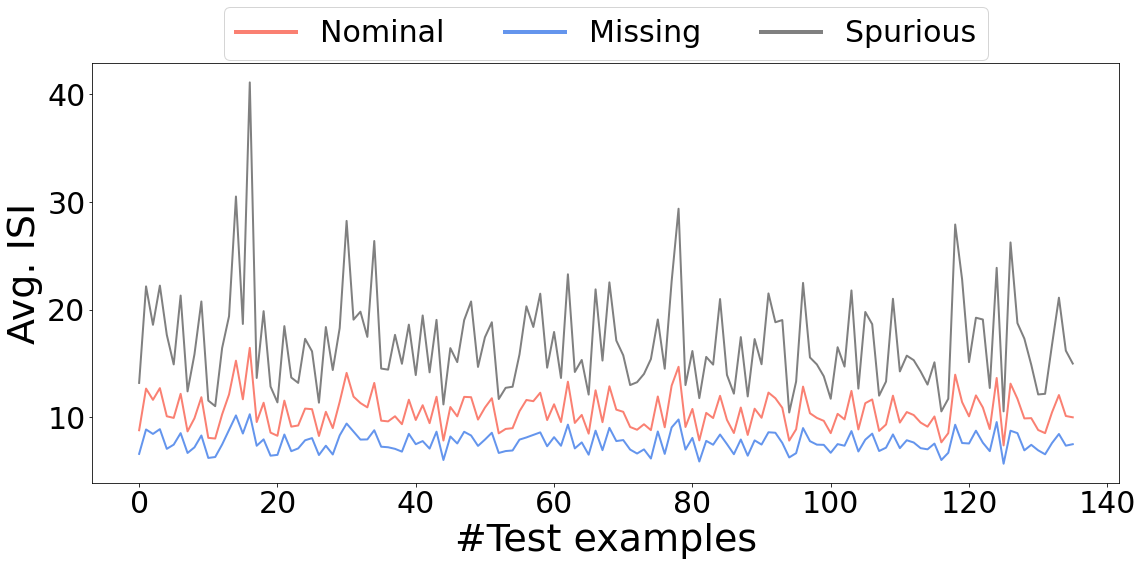

In [44]:
# y_nominal
# y_spurious_15 
# y_miss_15
num =200
plt.figure(figsize = (16,8))
plt.plot(y_nominal,linewidth=2, color = 'salmon')
plt.plot(y_spurious_15,linewidth=2, color = 'cornflowerblue')
plt.plot(y_miss_15,linewidth=2, color = 'gray')
plt.ylabel("Avg. ISI", fontsize=38)
plt.xlabel("#Test examples", fontsize=38)

plt.plot([], [], linestyle='-',linewidth=4, color ='salmon',label= 'Nominal')
plt.plot([], [], linestyle='-',linewidth=4, color ='cornflowerblue',label="Missing")
plt.plot([], [], linestyle='-',linewidth=4, color ='gray',label="Spurious")
plt.legend(bbox_to_anchor=(0.5, 1.17), loc='upper center', fontsize=30, ncol=3)
plt.tight_layout()
plt.savefig('nom_miss_spur_16.pdf',bbox_inches='tight')
plt.show()